same model as v1, improved train_test_split

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression 
from cinny import *

In [2]:
df = pd.read_csv('https://storage.googleapis.com/what-if-tool-resources/computefest2019/cox-violent-parsed_filt.csv')

In [3]:
# Filter out entries with no indication of recidivism or no compass score
df = df[df['is_recid'] != -1]
df = df[df['decile_score'] != -1]

# Rename recidivism column
df.rename(columns={'is_recid': 'recidivism_within_2_years'}, inplace=True)

# Make the COMPASS label column numeric (0 and 1), for use in our model
df['COMPASS_determination'] = np.where(df['score_text'] == 'Low', 0, 1)

In [4]:
df.head(2)

,id,name,first,last,sex,dob,age,age_cat,race,juv_fel_count,...,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,priors_count.1,event,COMPASS_determination
0,1.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,...,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0,0
1,2.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,...,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0,0


In [5]:
df.columns

Index(['id', 'name', 'first', 'last', 'sex', 'dob', 'age', 'age_cat', 'race',
       'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc',
       'recidivism_within_2_years', 'r_charge_degree', 'r_days_from_arrest',
       'r_offense_date', 'r_charge_desc', 'r_jail_in', 'violent_recid',
       'is_violent_recid', 'vr_charge_degree', 'vr_offense_date',
       'vr_charge_desc', 'type_of_assessment', 'decile_score.1', 'score_text',
       'screening_date', 'v_type_of_assessment', 'v_decile_score',
       'v_score_text', 'priors_count.1', 'event', 'COMPASS_determination'],
      dtype='object')

In [6]:
def sex_num(x):
    if x=='Male':
        return 1
    else:
        return 0

def race_num(x):
    if (x=='African-American') | (x=='Hispanic'):
        return 1
    else:
        return 0

In [7]:
df['sex_num'] = df['sex'].apply(sex_num)
df['race_num'] = df['race'].apply(race_num)

In [8]:
X = df[['sex_num', 'age', 'race_num', 'priors_count', 'juv_fel_count', 'juv_misd_count', 'juv_other_count']]
y = df['recidivism_within_2_years']

In [9]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split_pro(X, y, test_size=0.5)

In [10]:
X.dtypes

sex_num            int64
age                int64
race_num           int64
priors_count       int64
juv_fel_count      int64
juv_misd_count     int64
juv_other_count    int64
dtype: object

In [11]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [12]:
y_pred = lr.predict(X_test)

In [13]:
lr.score(X_test, y_test) #accuracy

0.6586565968646299

In [14]:
X_test['logit_v1'] = y_pred

In [15]:
test_df = pd.merge(X_test, y_test, left_index=True, right_index=True)

## compare to baseline model

In [16]:
get_accuracy(df)

0.6261799874134676

In [17]:
get_accuracy(test_df, pred_label='logit_v1')

0.6586565968646299

In [18]:
get_precision(df)

0.6002136752136752

In [19]:
get_precision(test_df, pred_label='logit_v1')

0.6361451574140832

In [20]:
get_recall(df)

0.6680142687277051

In [21]:
get_recall(test_df, pred_label='logit_v1') 

0.6431000971817298

We can see that a basic logistic regression model performs better than the COMPASS baseline model in terms of accuracy. We also see that our basic model has higher precision and lower recall, meaning that our model was more conservative in our prediction, and only predicted someone as likely to reoffend when we are very sure; while the COMPASS model tried to capture as many positives as possible.

## bias assessment

In [22]:
test_df.groupby(['race_num', 'recidivism_within_2_years', 'logit_v1']).count()['age']

race_num  recidivism_within_2_years  logit_v1
0         0                          0           1489
                                     1            510
          1                          0            645
                                     1            712
1         0                          0           1620
                                     1           1004
          1                          0            824
                                     1           1935
Name: age, dtype: int64

In [23]:
propublica_analysis(df)

(0.4885605338417541,
 0.511439466158246,
 0.6549643444871092,
 0.34503565551289084)

In [24]:
propublica_analysis(test_df, pred_label='logit_v1', race1=0, race2=1)

(0.44155844155844154,
 0.5584415584415584,
 0.5492341356673961,
 0.45076586433260396)

|COMPASS                                    | White, Asian, etc. | African American or Hispanic |
|-------------------------------------------|--------------------|-------------------------------------|
| Labeled Higher Risk, But Didn’t Re-Offend | 48%                | 65%              |
| Labeled Lower Risk, Yet Did Re-Offend     | 51%                | 34%              |



|logit_v1 (30% test_size)                   | White, Asian, etc. | African American or Hispanic |
|-------------------------------------------|--------------------|-------------------------------------|
| Labeled Higher Risk, But Didn’t Re-Offend | 33%                | 63%              |
| Labeled Lower Risk, Yet Did Re-Offend     | 67%                | 37%              |


|logit_v1 (50% test_size)                   | White, Asian, etc. | African American or Hispanic |
|-------------------------------------------|--------------------|-------------------------------------|
| Labeled Higher Risk, But Didn’t Re-Offend | 44%                | 54%              |
| Labeled Lower Risk, Yet Did Re-Offend     | 55%                | 45%              |


|logit_v1 (70% test_size)                   | White, Asian, etc. | African American or Hispanic |
|-------------------------------------------|--------------------|-------------------------------------|
| Labeled Higher Risk, But Didn’t Re-Offend | 33%                | 41%              |
| Labeled Lower Risk, Yet Did Re-Offend     | 66%                | 58%              |

Using the same logit model, this time splitting the data proportion to the population composition of the race group, we see that the logit model does not really present bias to either group, and makes prediction rather equally, with a slight bias to the White group still. We also see that the bias increases as the train size data decreases...?

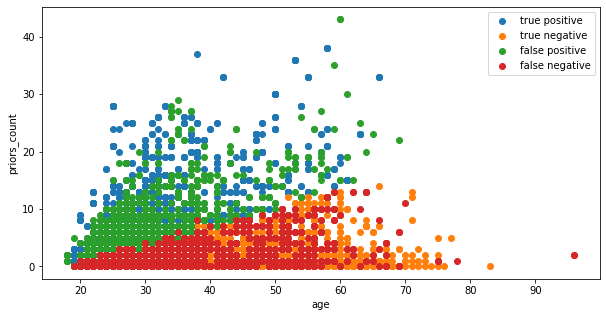

In [25]:
plot_scatter(test_df, pred_label='logit_v1')

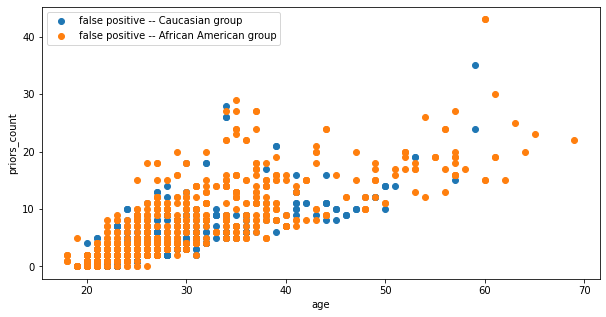

In [26]:
plot_scatter(test_df, pred_label='logit_v1', race=True, false_negative=False)